<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Split-Train/Test/Validation" data-toc-modified-id="Split-Train/Test/Validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Split Train/Test/Validation</a></span></li><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baseline model</a></span></li><li><span><a href="#Models-Training" data-toc-modified-id="Models-Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models Training</a></span><ul class="toc-item"><li><span><a href="#Light-Gradient-Boosting-Machine-(LGBM)" data-toc-modified-id="Light-Gradient-Boosting-Machine-(LGBM)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Light Gradient Boosting Machine (LGBM)</a></span></li></ul></li></ul></div>

# Libraries

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Split Train/Test/Validation

In [2]:
data = pd.read_csv('data/eda_dataset_imputed.csv')

app_train, test_1 = train_test_split(data, test_size=0.30, random_state=64)
app_test, app_validation = train_test_split(test_1, test_size=0.5, random_state=56)

In [3]:
app_train.shape, app_test.shape, app_validation.shape

((215257, 450), (46127, 450), (46127, 450))

# Baseline model

In [4]:
train_labels = app_train['TARGET']
test_labels = app_test['TARGET']

In [5]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(['TARGET'], axis=1)
else:
    train = app_train.copy()

    
if 'TARGET' in app_test:
    test = app_test.drop(['TARGET'], axis=1)
else:
    test = app_test.copy()

if 'TARGET' in app_validation:
    validation = app_validation.drop(['TARGET'], axis=1)
else:
    validation = app_validation.copy()
    
    
# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)
validation = imputer.transform(validation)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
validation = scaler.transform(validation)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)
print('Validation data shape: ', validation.shape)

Training data shape:  (215257, 449)
Testing data shape:  (46127, 449)
Validation data shape:  (46127, 449)


In [6]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [7]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error

print("ROC AUC: ", roc_auc_score(test_labels, log_reg_pred))
print("MAE: ", mean_absolute_error(test_labels, log_reg_pred))

ROC AUC:  0.713790323186
MAE:  0.149072307289


# Models Training

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.utils.multiclass import type_of_target

import gc

def model(model_func, features, test_features, params, validation_features=None, n_folds = 5): 
    """Train, test and validation a model using cross validation. 
    
    Parameters
    --------
        model_func:
            Function call that train the specific model
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        params
            Params set that will be passed to the model
        validation_features (pd.DataFrame): 
            dataframe of validation features to use
            for making predictions with the model. 
        
        
    Return
    --------
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC, MAE) for each fold and overall.
        validation_metrics (pd.DataFrame): 
            dataframe with metrics (ROC AUC, MAE) for validation dataframe.
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    if validation_features is not None:
        validation_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = np.array(features['TARGET'].astype(int))
    test_labels = np.array(test_features['TARGET'].astype(int))
    if validation_features is not None:
        validation_labels = np.array(validation_features['TARGET'].astype(int))
    
    # Remove the ids and target
    features = features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    test_features = test_features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    if validation_features is not None:
        validation_features = validation_features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    if validation_features is not None:
        print('Validation Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    if validation_features is not None:
        validation_features = np.array(validation_features)
        
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    if validation_features is not None:
        validation_predictions = np.zeros(validation_features.shape[0])
        
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores_auc = []
    train_scores_auc = []
    valid_scores_mae = []
    train_scores_mae = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        valid_score_auc, train_score_auc, valid_score_mae, train_score_mae, feature_importance_values_l, test_predictions_l, validation_predictions_l = model_func(train_features, train_labels, valid_features, valid_labels, test_features, validation_features, params)

        # Record the feature importances
        feature_importance_values += feature_importance_values_l / k_fold.n_splits

        # Make predictions
        test_predictions += test_predictions_l / k_fold.n_splits
        if validation_features is not None:
            validation_predictions += validation_predictions_l / k_fold.n_splits
        
        valid_scores_auc.append(valid_score_auc)
        train_scores_auc.append(train_score_auc)
        valid_scores_mae.append(valid_score_mae)
        train_scores_mae.append(train_score_mae)
        
        # Clean up memory
        gc.enable()
        del train_features, valid_features
        gc.collect()
        
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(test_labels, test_predictions)
    valid_mae = mean_absolute_error(test_labels, test_predictions)
    if validation_features is not None:
        validation_auc = roc_auc_score(validation_labels, validation_predictions)
        validation_mae = mean_absolute_error(validation_labels, validation_predictions)
    
    # Add the overall scores to the metrics
    valid_scores_auc.append(valid_auc)
    train_scores_auc.append(np.mean(train_scores_auc))
    valid_scores_mae.append(valid_mae)
    train_scores_mae.append(np.mean(train_scores_mae))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train auc': train_scores_auc,
                            'valid auc': valid_scores_auc,
                            'train mae': train_scores_mae,
                            'valid mae': valid_scores_mae}) 

    if validation_features is not None:
        validation_metrics = pd.DataFrame({'auc': [validation_auc],
                                           'mae': [validation_mae]}) 
    else:
        validation_metrics = None
        

    return feature_importances, metrics, validation_metrics

In [10]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

## Light Gradient Boosting Machine (LGBM)

In [11]:
import lightgbm as lgb

def train_LGBMClassifier(train_features, train_labels, valid_features, valid_labels, test_features, validation_features, params):
    # Create the model
    model = lgb.LGBMClassifier(application="binary", boosting_type=params["boosting"],
                      learning_rate=params["learning_rate"],n_estimators=params["n_estimators"],
                      reg_alpha = params["reg_alpha"], reg_lambda = params["reg_lambda"], 
                      drop_rate=params["drop_rate"],
                      num_leaves=params["num_leaves"], max_depth=params["max_depth"],
                      max_bin=params["max_bin"],
                      subsample = 0.8, n_jobs = -1, random_state = 50)
    
    # Train the model
    model.fit(train_features, train_labels, eval_metric = ['auc', 'mae'],
              eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
              eval_names = ['valid', 'train'],
              early_stopping_rounds = params["early_stopping_rounds"], verbose = 200)
    
    # Record the best iteration
    best_iteration = model.best_iteration_
    
    # Record the feature importances
    feature_importance_values = model.feature_importances_
    
    # Make predictions
    test_predictions = model.predict_proba(test_features, num_iteration = best_iteration)[:, 1]
    if validation_features is not None:
        validation_predictions = model.predict_proba(validation_features, num_iteration = best_iteration)[:, 1]
    else:
        validation_predictions=None
        
    # Record the best score
    valid_score_auc = model.best_score_['valid']['auc']
    train_score_auc = model.best_score_['train']['auc']
    valid_score_mae = model.best_score_['valid']['l1']
    train_score_mae = model.best_score_['train']['l1']

    return valid_score_auc, train_score_auc, valid_score_mae, train_score_mae, feature_importance_values, test_predictions, validation_predictions

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13828	valid's auc: 0.754166	train's l1: 0.130299	train's auc: 0.878715
Early stopping, best iteration is:
[192]	valid's l1: 0.137714	valid's auc: 0.754396	train's l1: 0.129895	train's auc: 0.877069
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138973	valid's auc: 0.751239	train's l1: 0.129854	train's auc: 0.878984
[400]	valid's l1: 0.137259	valid's auc: 0.75119	train's l1: 0.123386	train's auc: 0.919337
Early stopping, best iteration is:
[285]	valid's l1: 0.138821	valid's auc: 0.751671	train's l1: 0.127401	train's auc: 0.899392
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138045	valid's auc: 0.740117	train's l1: 0.130667	train's auc: 0.87692
[400]	valid's l1: 0.1364	valid's auc: 0.741486	train's l1: 0.123798	train's auc: 0.917226
[600]	valid's l1: 0.134829	valid

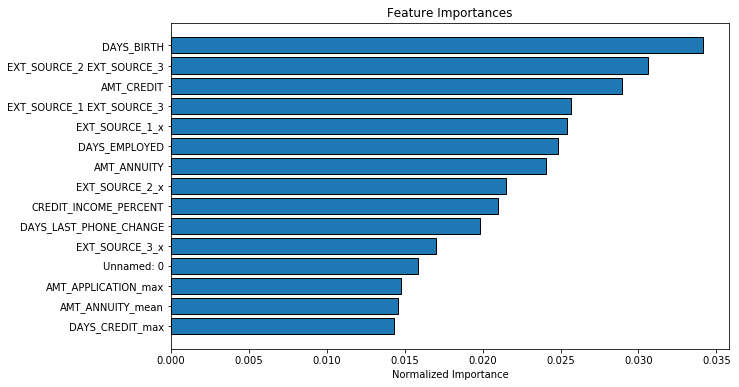

In [12]:
lgbm_params = {
    "boosting":"dart",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.01,
    'reg_lambda': 0.01,
    "n_estimators":10000,
    "max_depth":7,
    "num_leaves":100,
    "max_bin":225,
    "drop_rate":0.02,
    "early_stopping_rounds": 200
}

fi, metrics, validation_metrics = model(train_LGBMClassifier, app_train, app_test, params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133782	valid's auc: 0.7506	train's l1: 0.120064	train's auc: 0.912934
Early stopping, best iteration is:
[86]	valid's l1: 0.135583	valid's auc: 0.754204	train's l1: 0.128797	train's auc: 0.857283
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134541	valid's auc: 0.748257	train's l1: 0.119671	train's auc: 0.911534
Early stopping, best iteration is:
[97]	valid's l1: 0.13609	valid's auc: 0.750568	train's l1: 0.127534	train's auc: 0.864312
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133348	valid's auc: 0.739781	train's l1: 0.120461	train's auc: 0.909081
Early stopping, best iteration is:
[98]	valid's l1: 0.134877	valid's auc: 0.741182	train's l1: 0.127649	train's auc: 0.865789
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134689	

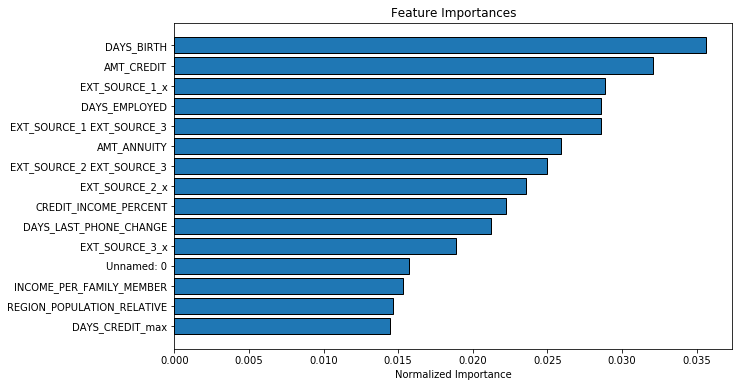

In [14]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.1,
    'reg_lambda': 0.1,
    "n_estimators":10000,
    "max_depth":7,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02,
    "early_stopping_rounds": 200
}

fi, metrics, validation_metrics = model(train_LGBMClassifier, app_train, app_test, params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135621	valid's auc: 0.755764	train's l1: 0.131104	train's auc: 0.828261
Early stopping, best iteration is:
[134]	valid's l1: 0.135961	valid's auc: 0.756757	train's l1: 0.133003	train's auc: 0.809402
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136436	valid's auc: 0.751696	train's l1: 0.130652	train's auc: 0.828086
Early stopping, best iteration is:
[104]	valid's l1: 0.13708	valid's auc: 0.752171	train's l1: 0.133561	train's auc: 0.800085
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135294	valid's auc: 0.74148	train's l1: 0.131054	train's auc: 0.829337
Early stopping, best iteration is:
[157]	valid's l1: 0.135511	valid's auc: 0.742536	train's l1: 0.132307	train's auc: 0.817467
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136

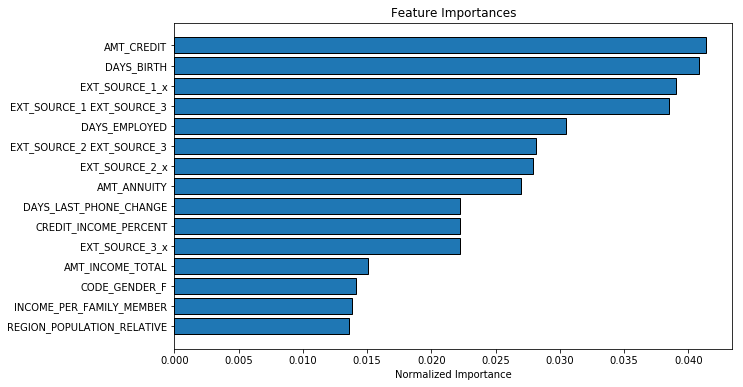

In [15]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.1,
    'reg_lambda': 0.1,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02,
    "early_stopping_rounds": 200
}

fi, metrics, validation_metrics = model(train_LGBMClassifier, app_train, app_test, params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135633	valid's auc: 0.7586	train's l1: 0.132768	train's auc: 0.805001
Early stopping, best iteration is:
[199]	valid's l1: 0.135634	valid's auc: 0.758607	train's l1: 0.132783	train's auc: 0.804923
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136347	valid's auc: 0.754799	train's l1: 0.132395	train's auc: 0.805111
[400]	valid's l1: 0.135693	valid's auc: 0.753615	train's l1: 0.128439	train's auc: 0.843778
Early stopping, best iteration is:
[224]	valid's l1: 0.136259	valid's auc: 0.755165	train's l1: 0.131917	train's auc: 0.810282
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135206	valid's auc: 0.744283	train's l1: 0.132781	train's auc: 0.806472
[400]	valid's l1: 0.134608	valid's auc: 0.744294	train's l1: 0.128805	train's auc: 0.845441
Early stopping, best iteratio

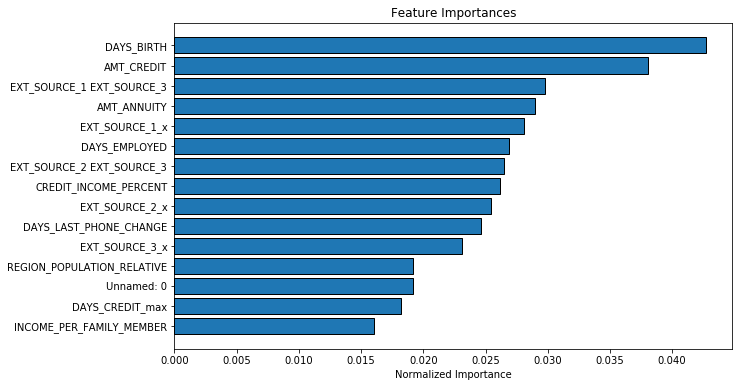

In [16]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':10,
    'reg_lambda': 10,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02,
    "early_stopping_rounds": 200
}

fi, metrics, validation_metrics = model(train_LGBMClassifier, app_train, app_test, params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136681	valid's auc: 0.755703	train's l1: 0.136538	train's auc: 0.762495
Early stopping, best iteration is:
[167]	valid's l1: 0.136691	valid's auc: 0.75572	train's l1: 0.13655	train's auc: 0.762467
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137482	valid's auc: 0.751297	train's l1: 0.136209	train's auc: 0.762437
Early stopping, best iteration is:
[160]	valid's l1: 0.137598	valid's auc: 0.751304	train's l1: 0.136328	train's auc: 0.762417
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136303	valid's auc: 0.738559	train's l1: 0.136652	train's auc: 0.765354
Early stopping, best iteration is:
[162]	valid's l1: 0.136303	valid's auc: 0.738559	train's l1: 0.136652	train's auc: 0.765354
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.137

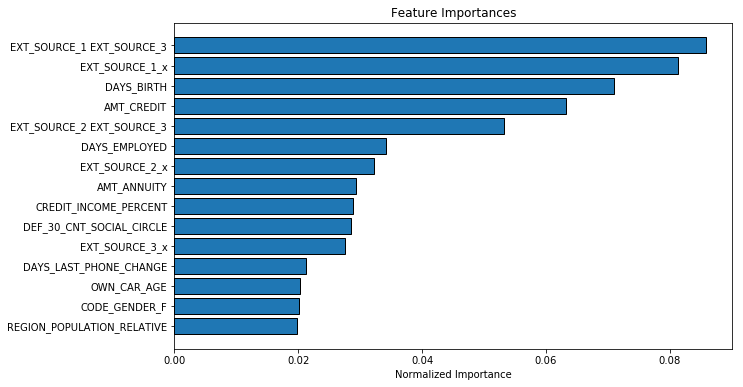

In [17]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':100,
    'reg_lambda': 100,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02,
    "early_stopping_rounds": 200
}

fi, metrics, validation_metrics = model(train_LGBMClassifier, app_train, app_test, params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Validation Data Shape:  (46127, 448)
Training until validation scores don't improve for 500 rounds.
[200]	valid's l1: 0.140336	valid's auc: 0.742289	train's l1: 0.140712	train's auc: 0.746658
[400]	valid's l1: 0.138343	valid's auc: 0.750942	train's l1: 0.138334	train's auc: 0.761237
[600]	valid's l1: 0.1374	valid's auc: 0.754757	train's l1: 0.137016	train's auc: 0.769987
[800]	valid's l1: 0.136813	valid's auc: 0.756723	train's l1: 0.136048	train's auc: 0.776413
[1000]	valid's l1: 0.136445	valid's auc: 0.758149	train's l1: 0.135332	train's auc: 0.781594
[1200]	valid's l1: 0.136231	valid's auc: 0.758549	train's l1: 0.134781	train's auc: 0.786496
[1400]	valid's l1: 0.136066	valid's auc: 0.758931	train's l1: 0.134288	train's auc: 0.790999
[1600]	valid's l1: 0.135911	valid's auc: 0.759173	train's l1: 0.133824	train's auc: 0.795316
[1800]	valid's l1: 0.135798	valid's auc: 0.759327	train's l1: 0.133397	train's auc: 0.799566

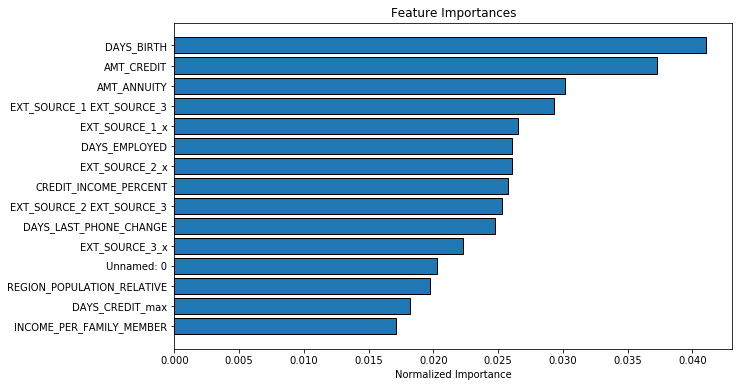

       auc       mae
0  0.75427  0.136778


In [18]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.01,
    'reg_alpha':10,
    'reg_lambda': 10,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02,
    "early_stopping_rounds": 500
}

fi, metrics, validation_metrics = model(train_LGBMClassifier, app_train, app_test, params=lgbm_params, validation_features=app_validation)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)
print(validation_metrics)

## XGBoost

In [19]:
import xgboost as xgb
def train_XGBoostClassifier(train_features, train_labels, valid_features, valid_labels, test_features, validation_features, params):
    # Create the model
    model = xgb.XGBClassifier(learning_rate =params["learning_rate"], 
                              n_estimators=params["n_estimators"], 
                              max_depth=params["max_depth"], 
                              min_child_weight=params["min_child_weight"], 
                              subsample=params["subsample"], 
                              colsample_bytree=params["colsample_bytree"], 
                              objective= 'binary:logistic', 
                              nthread=4, 
                              scale_pos_weight=2, 
                              seed=27)
    
    # Train the model
    model.fit(train_features, train_labels, eval_metric = ['mae', 'auc'],
              eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
              #eval_names = ['valid', 'train'],
              early_stopping_rounds = params["early_stopping_rounds"], verbose = 200)
    
    # Record the best iteration
    best_iteration = model.best_iteration
    
    # Record the feature importances
    feature_importance_values = model.feature_importances_
    
    # Make predictions
    test_predictions = model.predict_proba(test_features)[:, 1]
    if validation_features is not None:
        validation_predictions = model.predict_proba(validation_features)[:, 1]
    else:
        validation_predictions=None
        
    # Record the best score
    valid_score_auc = model.evals_result()['validation_1']['auc'][best_iteration]
    train_score_auc = model.evals_result()['validation_0']['auc'][best_iteration]
    valid_score_mae = model.evals_result()['validation_1']['mae'][best_iteration]
    train_score_mae = model.evals_result()['validation_0']['mae'][best_iteration]

    return valid_score_auc, train_score_auc, valid_score_mae, train_score_mae, feature_importance_values, test_predictions, validation_predictions


Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
[0]	validation_0-mae:0.46859	validation_0-auc:0.728675	validation_1-mae:0.46869	validation_1-auc:0.716674
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-mae:0.158889	validation_0-auc:0.896717	validation_1-mae:0.173504	validation_1-auc:0.751329
Stopping. Best iteration:
[92]	validation_0-mae:0.169175	validation_0-auc:0.850049	validation_1-mae:0.177439	validation_1-auc:0.75529

[0]	validation_0-mae:0.46862	validation_0-auc:0.729919	validation_1-mae:0.468828	validation_1-auc:0.719317
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-mae:0.157096	validation_0-auc:0.899943	validation_1-mae:0.173667	validation_1-auc:0.745748
Stopping. Best iteration:
[104]	validation_0-m

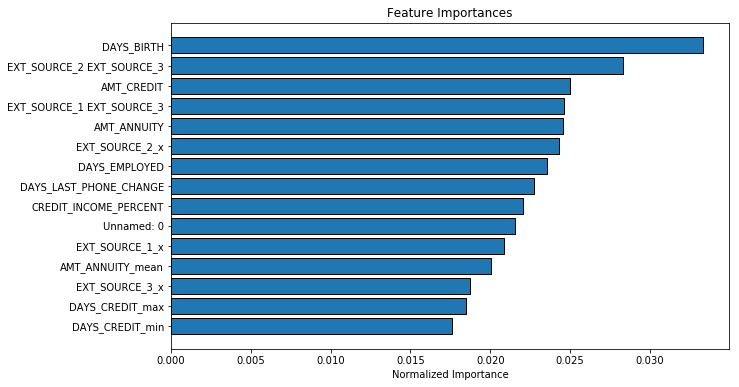

In [20]:
params = {
    "learning_rate": 0.1,
    "n_estimators":10000,
    "max_depth":7,
    "min_child_weight": 4,
    "subsample": 0.8, 
    "colsample_bytree": 0.8,
    "early_stopping_rounds": 200
}

fi, metrics, validation_metrics = model(train_XGBoostClassifier, app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
[0]	validation_0-mae:0.468861	validation_0-auc:0.717275	validation_1-mae:0.46887	validation_1-auc:0.715851
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-mae:0.17482	validation_0-auc:0.805535	validation_1-mae:0.17892	validation_1-auc:0.756529
Stopping. Best iteration:
[134]	validation_0-mae:0.176994	validation_0-auc:0.791673	validation_1-mae:0.179782	validation_1-auc:0.75702

[0]	validation_0-mae:0.468919	validation_0-auc:0.715972	validation_1-mae:0.469044	validation_1-auc:0.712803
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-mae:0.174055	validation_0-auc:0.803856	validation_1-mae:0.179015	validation_1-auc:0.752185
Stopping. Best iteration:
[138]	validation_0-

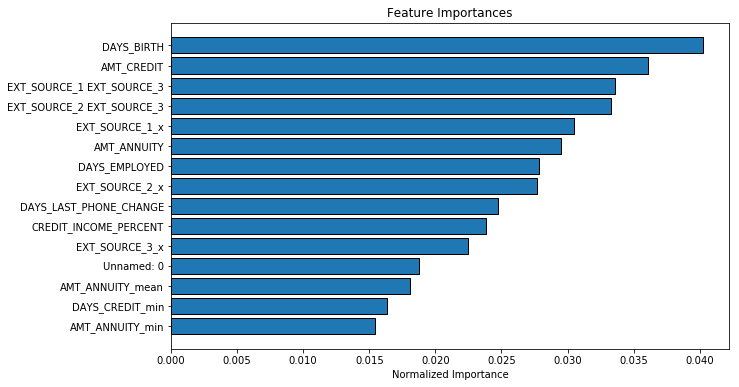

In [21]:
params = {
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "max_depth":5,
    "min_child_weight": 40,
    "subsample": 0.7, 
    "colsample_bytree": 0.8,
    "early_stopping_rounds": 200
}

fi, metrics, validation_metrics = model(train_XGBoostClassifier, app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
[0]	validation_0-mae:0.469386	validation_0-auc:0.687941	validation_1-mae:0.46934	validation_1-auc:0.686453
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-mae:0.174818	validation_0-auc:0.804788	validation_1-mae:0.17893	validation_1-auc:0.756218
Stopping. Best iteration:
[124]	validation_0-mae:0.177472	validation_0-auc:0.787774	validation_1-mae:0.179915	validation_1-auc:0.75722

[0]	validation_0-mae:0.469368	validation_0-auc:0.68892	validation_1-mae:0.469505	validation_1-auc:0.682064
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-mae:0.174454	validation_0-auc:0.801518	validation_1-mae:0.179182	validation_1-auc:0.752626
Stopping. Best iteration:
[163]	validation_0-

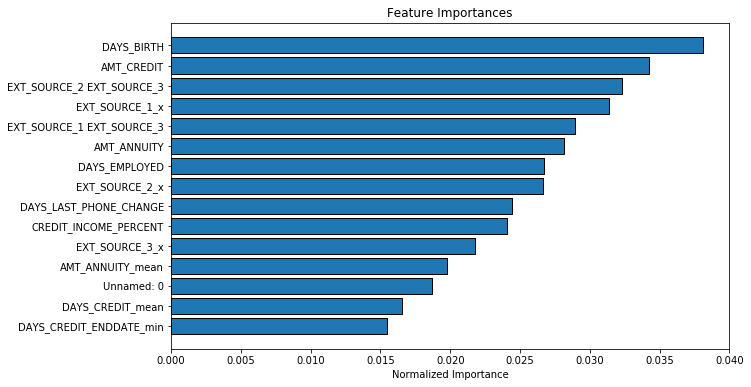

In [22]:
params = {
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "max_depth":5,
    "min_child_weight": 40,
    "subsample": 0.7, 
    "colsample_bytree": 0.6,
    "early_stopping_rounds": 200
}

fi, metrics, validation_metrics = model(train_XGBoostClassifier, app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
[0]	validation_0-mae:0.46909	validation_0-auc:0.700816	validation_1-mae:0.469066	validation_1-auc:0.703181
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-mae:0.180095	validation_0-auc:0.769275	validation_1-mae:0.181003	validation_1-auc:0.758304
[400]	validation_0-mae:0.177482	validation_0-auc:0.785671	validation_1-mae:0.179797	validation_1-auc:0.75871
Stopping. Best iteration:
[243]	validation_0-mae:0.179133	validation_0-auc:0.773304	validation_1-mae:0.180331	validation_1-auc:0.75915

[0]	validation_0-mae:0.469151	validation_0-auc:0.700088	validation_1-mae:0.46926	validation_1-auc:0.700269
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-mae:0.179194	validation_0-

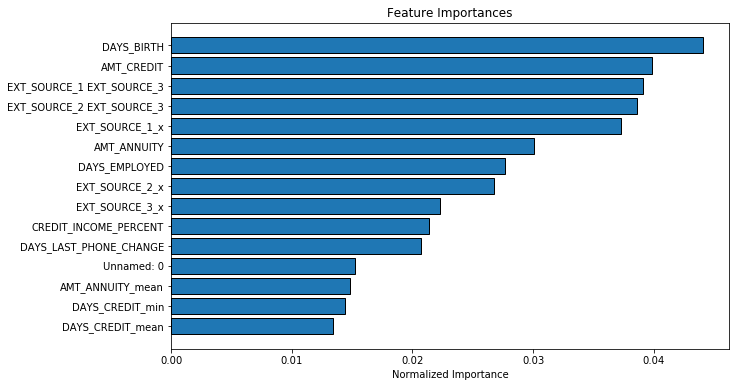

In [23]:
params = {
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "max_depth":3,
    "min_child_weight": 40,
    "subsample": 0.7, 
    "colsample_bytree": 0.8,
    "early_stopping_rounds": 200
}

fi, metrics, validation_metrics = model(train_XGBoostClassifier, app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Validation Data Shape:  (46127, 448)
[0]	validation_0-mae:0.496932	validation_0-auc:0.687941	validation_1-mae:0.496928	validation_1-auc:0.686453
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
[200]	validation_0-mae:0.228696	validation_0-auc:0.746972	validation_1-mae:0.22864	validation_1-auc:0.743556
[400]	validation_0-mae:0.190047	validation_0-auc:0.759875	validation_1-mae:0.190386	validation_1-auc:0.750531
[600]	validation_0-mae:0.182678	validation_0-auc:0.770829	validation_1-mae:0.183554	validation_1-auc:0.755437
[800]	validation_0-mae:0.180207	validation_0-auc:0.778195	validation_1-mae:0.181617	validation_1-auc:0.757769
[1000]	validation_0-mae:0.178847	validation_0-auc:0.783674	validation_1-mae:0.180711	validation_1-auc:0.758837
[1200]	validation_0-mae:0.177901	validation_0-auc:0.788712	validation_1-mae:0

[200]	validation_0-mae:0.227629	validation_0-auc:0.747519	validation_1-mae:0.229327	validation_1-auc:0.734319
[400]	validation_0-mae:0.188952	validation_0-auc:0.760799	validation_1-mae:0.191169	validation_1-auc:0.742421
[600]	validation_0-mae:0.181699	validation_0-auc:0.771616	validation_1-mae:0.184348	validation_1-auc:0.747699
[800]	validation_0-mae:0.179336	validation_0-auc:0.778891	validation_1-mae:0.182436	validation_1-auc:0.749752
[1000]	validation_0-mae:0.178084	validation_0-auc:0.784619	validation_1-mae:0.181614	validation_1-auc:0.750719
[1200]	validation_0-mae:0.177097	validation_0-auc:0.789298	validation_1-mae:0.181021	validation_1-auc:0.751
[1400]	validation_0-mae:0.176299	validation_0-auc:0.793877	validation_1-mae:0.180616	validation_1-auc:0.751086
[1600]	validation_0-mae:0.175543	validation_0-auc:0.798344	validation_1-mae:0.180253	validation_1-auc:0.751179
[1800]	validation_0-mae:0.174842	validation_0-auc:0.802737	validation_1-mae:0.17995	validation_1-auc:0.751108
[2000]	va

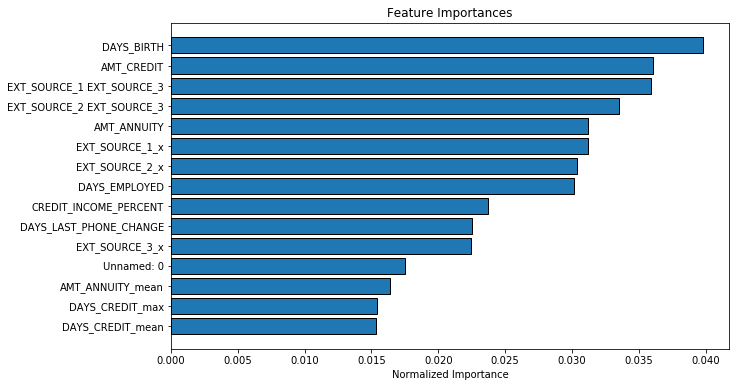

       auc       mae
0  0.75406  0.178741


In [24]:
params = {
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "max_depth":5,
    "min_child_weight": 40,
    "subsample": 0.7, 
    "colsample_bytree": 0.6,
    "early_stopping_rounds": 500
}

fi, metrics, validation_metrics = model(train_XGBoostClassifier, app_train, app_test, params=params, validation_features=app_validation)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)
print(validation_metrics)

### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

def train_RandomForestClassifier(train_features, train_labels, valid_features, valid_labels, test_features, validation_features, params):
    # Create the model
    model = RandomForestClassifier(bootstrap=True, 
                                   class_weight="balanced", 
                                   criterion=params["criterion"],
                                   max_depth=params["max_depth"], 
                                   max_features=params["max_features"], 
                                   #max_leaf_nodes=None,
                                   #min_impurity_decrease=0.0, 
                                   #min_impurity_split=None,
                                   min_samples_leaf=params["min_samples_leaf"], 
                                   #min_samples_split=2,
                                   #min_weight_fraction_leaf=0.0,
                                   n_estimators=params["n_estimators"], 
                                   n_jobs=5,
                                   #oob_score=False, 
                                   random_state=562, 
                                   verbose=1,
                                   warm_start=False)
    
    # Train the model
    model.fit(train_features, train_labels)

    # Record the feature importances
    feature_importance_values = model.feature_importances_
    
    # Make predictions
    test_predictions = model.predict_proba(test_features)[:, 1]
    if validation_features is not None:
        validation_predictions = model.predict_proba(validation_features)[:, 1]
    else:
        validation_predictions=None
        
    # Record the best score
    t_p = model.predict_proba(train_features)[:, 1]
    v_p = model.predict_proba(valid_features)[:, 1]
    
    # Record the best score
    valid_score_auc = roc_auc_score(valid_labels, v_p)
    train_score_auc = roc_auc_score(train_labels, t_p)
    valid_score_mae = mean_absolute_error(valid_labels, v_p)
    train_score_mae = mean_absolute_error(train_labels, t_p)

    return valid_score_auc, train_score_auc, valid_score_mae, train_score_mae, feature_importance_values, test_predictions, validation_predictions


Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   44.6s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   44.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: 

Baseline metrics
      fold  train auc  train mae  valid auc  valid mae
0        0   0.759904   0.409665   0.741787   0.411540
1        1   0.760915   0.408664   0.734702   0.412100
2        2   0.762896   0.406850   0.724648   0.410323
3        3   0.760017   0.408794   0.738650   0.410825
4        4   0.761367   0.408652   0.732457   0.411331
5  overall   0.761020   0.408525   0.734723   0.410938


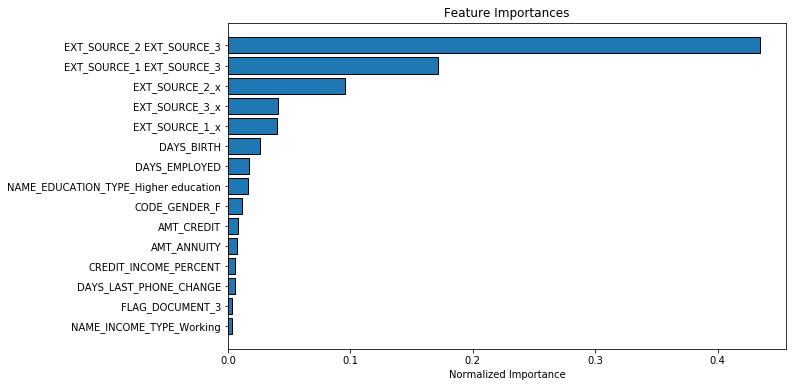

In [26]:
params = {
    "criterion": 'gini',
    "n_estimators":100,
    "max_features": 0.5,
    "max_depth":7,
    "min_samples_leaf": 4
}

fi, metrics, validation_metrics = model(train_RandomForestClassifier, app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   50.9s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   51.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: 

Baseline metrics
      fold  train auc  train mae  valid auc  valid mae
0        0   0.735183   0.423747   0.735119   0.423765
1        1   0.735956   0.422874   0.728028   0.424444
2        2   0.738544   0.420907   0.718466   0.422266
3        3   0.735274   0.422795   0.732384   0.422963
4        4   0.736174   0.422778   0.726150   0.423549
5  overall   0.736226   0.422620   0.727744   0.423153


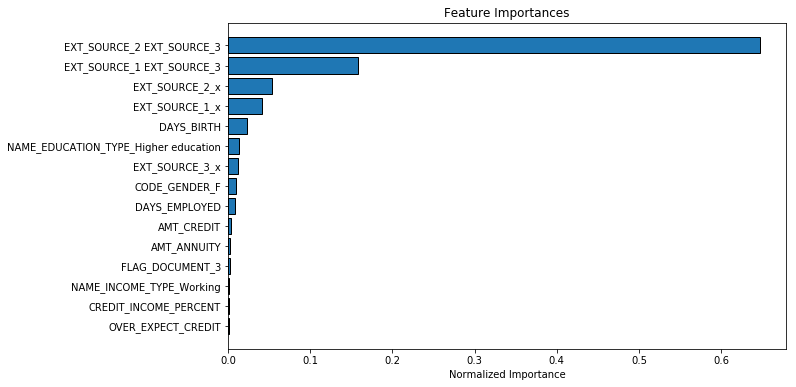

In [27]:
params = {
    "criterion": 'gini',
    "n_estimators":100,
    "max_features": 0.8,
    "max_depth":5,
    "min_samples_leaf": 4
}

fi, metrics, validation_metrics = model(train_RandomForestClassifier, app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   43.7s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   43.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: 

Baseline metrics
      fold  train auc  train mae  valid auc  valid mae
0        0   0.926550   0.289208   0.744100   0.314891
1        1   0.925686   0.289249   0.736777   0.316380
2        2   0.924945   0.287979   0.725958   0.315013
3        3   0.926133   0.288641   0.740449   0.314594
4        4   0.923894   0.289539   0.732389   0.315825
5  overall   0.925442   0.288923   0.738860   0.315060


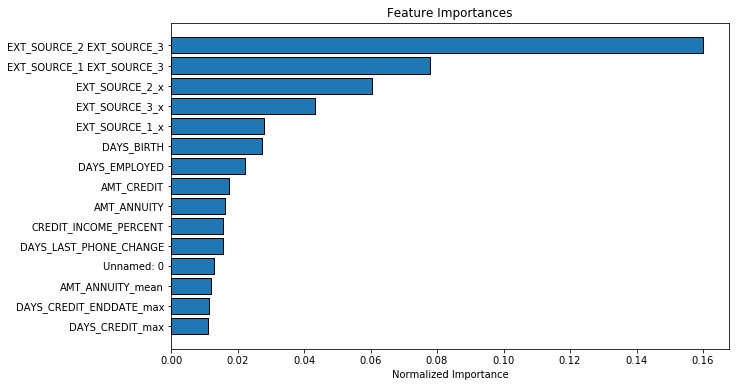

In [28]:
params = {
    "criterion": 'gini',
    "n_estimators":100,
    "max_features": 0.3,
    "max_depth":14,
    "min_samples_leaf": 4
}

fi, metrics, validation_metrics = model(train_RandomForestClassifier, app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: 

Baseline metrics
      fold  train auc  train mae  valid auc  valid mae
0        0   0.815105   0.373213   0.745629   0.380206
1        1   0.814446   0.372441   0.739788   0.380838
2        2   0.815203   0.371080   0.728473   0.379795
3        3   0.814402   0.372694   0.743991   0.379744
4        4   0.814211   0.372767   0.735912   0.380733
5  overall   0.814673   0.372439   0.738920   0.379872


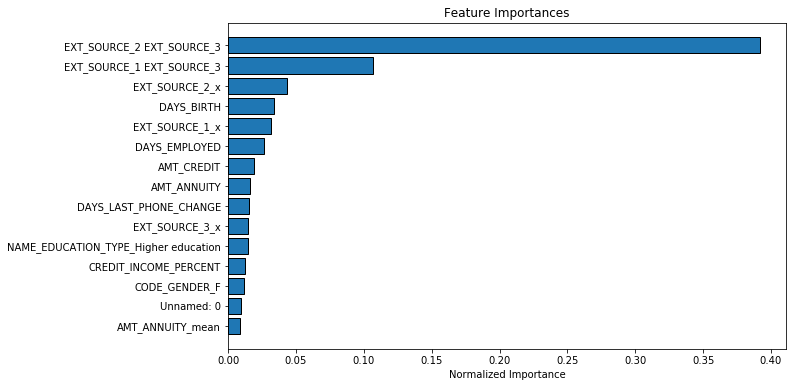

In [29]:
params = {
    "criterion": 'gini',
    "n_estimators":100,
    "max_features": 0.8,
    "max_depth":14,
    "min_samples_leaf": 0.001
}

fi, metrics, validation_metrics = model(train_RandomForestClassifier, app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: 

Baseline metrics
      fold  train auc  train mae  valid auc  valid mae
0        0   0.820753   0.369735   0.745213   0.377525
1        1   0.820663   0.368565   0.739514   0.377810
2        2   0.821364   0.367316   0.728891   0.376652
3        3   0.819900   0.368881   0.743690   0.376652
4        4   0.820343   0.368749   0.735662   0.377577
5  overall   0.820605   0.368649   0.739126   0.376692


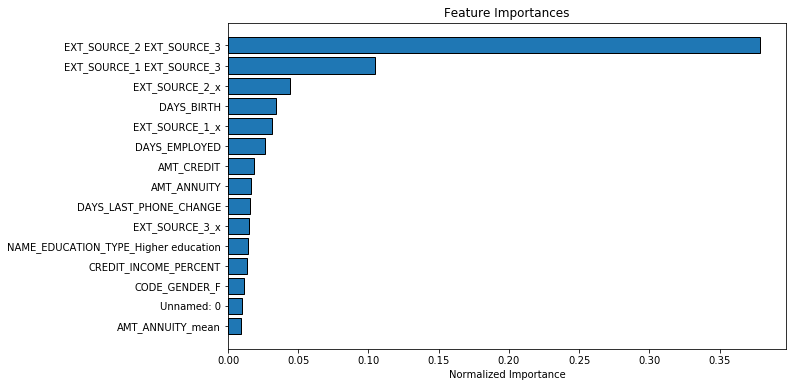

In [30]:
params = {
    "criterion": 'gini',
    "n_estimators":100,
    "max_features": 0.8,
    "max_depth":28,
    "min_samples_leaf": 0.001
}

fi, metrics, validation_metrics = model(train_RandomForestClassifier, app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  5.0min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  5.0min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: 

Baseline metrics
      fold  train auc  train mae  valid auc  valid mae
0        0   0.815388   0.373200   0.746080   0.380173
1        1   0.815111   0.372392   0.740998   0.380935
2        2   0.815915   0.370648   0.729871   0.379199
3        3   0.815084   0.372327   0.744994   0.379420
4        4   0.814882   0.372458   0.736681   0.380563
5  overall   0.815276   0.372205   0.739742   0.379643


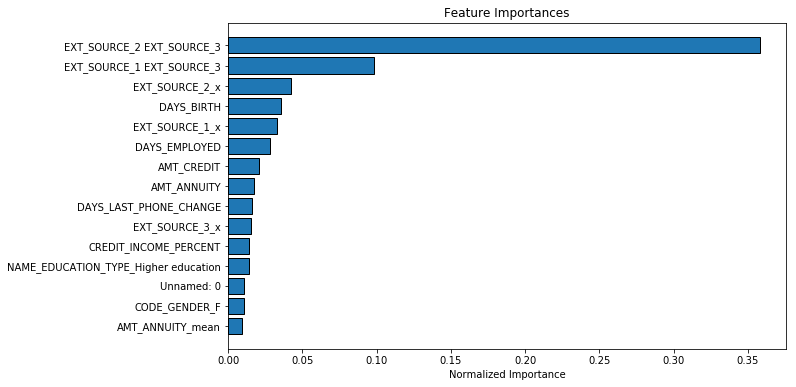

In [31]:
params = {
    "criterion": 'entropy',
    "n_estimators":100,
    "max_features": 0.8,
    "max_depth":14,
    "min_samples_leaf": 0.001
}

fi, metrics, validation_metrics = model(train_RandomForestClassifier, app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Validation Data Shape:  (46127, 448)


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  7.5min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 17.3min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 32.3min
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed: 40.8min finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:

Baseline metrics
      fold  train auc  train mae  valid auc  valid mae
0        0   0.815903   0.373415   0.745989   0.380471
1        1   0.815756   0.372505   0.740438   0.381075
2        2   0.816085   0.371522   0.729519   0.380275
3        3   0.815061   0.372933   0.744043   0.380089
4        4   0.815200   0.372551   0.736795   0.380621
5  overall   0.815601   0.372585   0.739247   0.379972


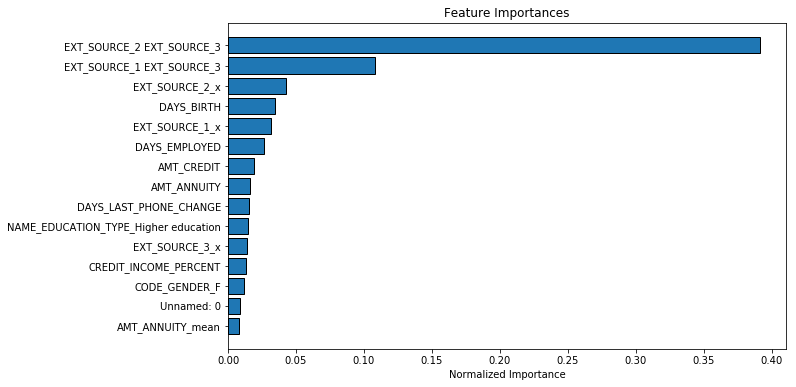

        auc       mae
0  0.741533  0.379821


In [14]:
params = {
    "criterion": 'gini',
    "n_estimators": 1000,
    "max_features": 0.8,
    "max_depth":14,
    "min_samples_leaf": 0.001
}

fi, metrics, validation_metrics = model(train_RandomForestClassifier, app_train, app_test, params=params, validation_features=app_validation)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)
print(validation_metrics)